In [1]:
# ONLY ONCE: DOWNLOAD VGG19 weights 
#!wget https://partage.imt.fr/index.php/s/4tZx9KPTYJ5cr8L/download -O vgg19.npy
!wget https://perso.telecom-paris.fr/ladjal/TP3_DELIRES/vgg19/vgg19.npy -O vgg19.npy
!wget  https://perso.telecom-paris.fr/ladjal/TP3_DELIRES/images.tgz -O images.tgz
!tar xvzf images.tgz

--2023-03-29 20:11:18--  https://perso.telecom-paris.fr/ladjal/TP3_DELIRES/vgg19/vgg19.npy
Resolving perso.telecom-paris.fr (perso.telecom-paris.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paris.fr (perso.telecom-paris.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://perso.telecom-paristech.fr/ladjal/TP3_DELIRES/vgg19/vgg19.npy [following]
--2023-03-29 20:11:19--  https://perso.telecom-paristech.fr/ladjal/TP3_DELIRES/vgg19/vgg19.npy
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574670860 (548M)
Saving to: ‘vgg19.npy’

vgg19.npy           100%[===================>] 548.05M  11.5MB/s    in 48s     

2023-03-29 20:12:09 (11.3 MB/s) - ‘vgg19.npy’ saved [574670860/57467086

In [2]:
#import useful libraries
#%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
#import tensorflow as tf
import numpy as np
import os
import time
from functools import reduce
from skimage import io as skio
import skimage
import skimage.transform
import matplotlib.pyplot as plt

def load_image(path):
  
    img = skio.imread(path) / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()

    # Crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    shape = list(img.shape)

    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    resized_img = skimage.transform.resize(crop_img, (shape[0], shape[1]))
    return resized_img, shape

def render_img(session, x, save=False, out_path=None):
    shape = x.get_shape().as_list()
    img = np.clip(session.run(x), 0, 1.0)
    print(img.shape)
    if save:

        skio.imsave(out_path,img[0])
    else:
        viewimage(np.reshape(img, shape[1:]))
        #toimage(np.reshape(img, shape[1:])).show()




In [3]:
#VGG19 class definition
VGG_MEAN = [103.939, 116.779, 123.68]
data = None
weights_file='./vgg19.npy'

class Vgg19:
    def __init__(self, vgg19_npy_path=weights_file):
        global data


        if data is None:
            data = np.load(vgg19_npy_path, encoding='latin1',allow_pickle=True)
            self.data_dict = data.item()
            print("VGG19 weights loaded")

        else:
            self.data_dict = data.item()

    def build(self, rgb, shape):
        rgb_scaled = rgb * 255.0
        num_channels = shape[2]
        channel_shape = shape
        channel_shape[2] = 1

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)

        assert red.get_shape().as_list()[1:] == channel_shape
        assert green.get_shape().as_list()[1:] == channel_shape
        assert blue.get_shape().as_list()[1:] == channel_shape

        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])

        shape[2] = num_channels
        assert bgr.get_shape().as_list()[1:] == shape

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.avg_pool(self.conv1_2, 'pool1',self.filtre_moyenneur(64))

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.avg_pool(self.conv2_2, 'pool2',self.filtre_moyenneur(128))

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.conv3_4 = self.conv_layer(self.conv3_3, "conv3_4")
        self.pool3 = self.avg_pool(self.conv3_4, 'pool3',self.filtre_moyenneur(256))

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.conv4_4 = self.conv_layer(self.conv4_3, "conv4_4")
        self.pool4 = self.avg_pool(self.conv4_4, 'pool4',self.filtre_moyenneur(512))

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.conv5_4 = self.conv_layer(self.conv5_3, "conv5_4")

        self.data_dict = None

    def filtre_moyenneur(self,nbf):
        filtre=np.zeros((2,2,nbf,nbf),np.float32)
        for k in range(nbf):
            filtre[:,:,k,k]=0.25
        return filtre
    def avg_pool(self, bottom, name,filtre_inutile):
        return tf.nn.avg_pool(bottom,
            ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)
#    def avg_pool(self, bottom, name,filtre):
#        return tf.nn.conv2d(bottom,tf.constant(filtre),strides=[1,2,2,1],padding='SAME',name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom,
            ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")


In [28]:
#Useful functions for gatys texture synthsis
#GATYS Hyperparameters
#You must re-excute this cell after changing them
TEXTURE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

TEXTURE_LAYERS = ['conv1_1', 'conv1_2'] # only lower-level layers
#TEXTURE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1'] # combination of lower and middle-level layers
TEXTURE_LAYERS = ['conv2_1', 'conv3_1', 'conv3_2'] # only middle-level layers
TEXTURE_LAYERS = ['conv3_1', 'conv4_1', 'conv5_1'] # combination of middle and higher-level layers

EPOCHS = 1500
LEARNING_RATE = .02

NORM_TERM = 2.

# Loss term weights
TEXTURE_WEIGHT = 3.
NORM_WEIGHT = 0.1

#END HYPERPARAMETERS

# Calcul de la matrice de Gram d'un bloc convolutif
def convert_to_gram(filter_maps):
    # Get the dimensions of the filter maps to reshape them into two dimenions
    dimension = filter_maps.get_shape().as_list()
    reshaped_maps = tf.reshape(filter_maps, [dimension[1] * dimension[2], dimension[3]])

    # on normalise par la taille spatiale pour obtenir une valeur comparable entre images 
    return tf.matmul(reshaped_maps, reshaped_maps, transpose_a=True)/((dimension[1] * dimension[2]))


# Compute the L2-norm divided by squared number of dimensions
def get_l2_norm_loss(diffs):
    shape = diffs.get_shape().as_list()
    size = reduce(lambda x, y: x * y, shape) ** 2
    sum_of_squared_diffs = tf.reduce_sum(tf.square(diffs))
    return sum_of_squared_diffs / size


# Calcul de la loss texture etant donne le resaeau x et les matrices de gram s
def get_texture_loss(x, s):
    with tf.name_scope('get_style_loss'):
        texture_layer_losses = [get_texture_loss_for_layer(x, s, l) for l in TEXTURE_LAYERS]
        texture_weights = tf.constant([1. / len(texture_layer_losses)] * len(texture_layer_losses), tf.float32)
        weighted_layer_losses = tf.multiply(texture_weights, tf.convert_to_tensor(texture_layer_losses))
        return tf.reduce_sum(weighted_layer_losses)


# La loss texture pour une couche particuliere l
def get_texture_loss_for_layer(x, s, l):
    with tf.name_scope('get_style_loss_for_layer'):

        x_layer_maps = getattr(x, l)

        x_layer_gram = convert_to_gram(x_layer_maps)
        t_layer_gram = s[l] 

        shape = x_layer_maps.get_shape().as_list()
        size = shape[-1]**2 
        gram_loss = get_l2_norm_loss(x_layer_gram - t_layer_gram)
        return gram_loss / size



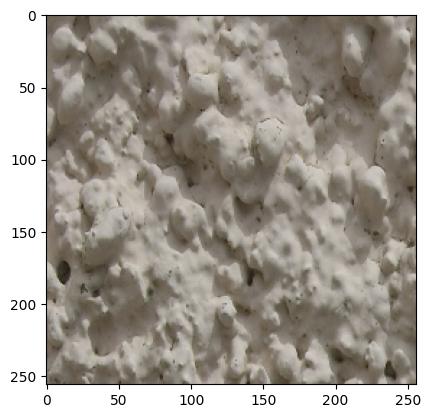

In [29]:
# Names of images to be created and mimicked 
OUT_PATH = 'sortie_gatys.png'
TEXTURE_PATH = 'images/CRW_3241_1024.png'
 
toto=load_image(TEXTURE_PATH)
plt.imshow(toto[0][:256,:256,:])

In [30]:
# Computation of the Gram matrices for the target texture
#Since these are constants, we compute them once and for all. 
#This is the only information we keep from the example texture
sess=tf.Session()

texture, image_shape = load_image(TEXTURE_PATH)
image_shape = [1] + image_shape
texture = texture.reshape(image_shape).astype(np.float32)
with tf.name_scope('vgg_texture'):
    texture_model = Vgg19()
    texture_model.build(texture, image_shape[1:])

grams={}
# calcul des matrices de gram de l'image d'origine
for l in TEXTURE_LAYERS:

    #tableau=sess.run(getattr(texture_model,l)) #gettattr renvoie texture_model.l
    tableau=(getattr(texture_model,l)).numpy()
    tableau=tableau.reshape(tableau.shape[1:])
    shape=tableau.shape

    tableau=tableau.reshape((shape[0]*shape[1],-1))

    grams[l]=np.matmul (tableau.T,tableau)/ (shape[0]*shape[1])

    

sess.close()


In [31]:
#Actual optimisation process to produce an image that mimicks the target texture
with tf.Session() as sess:
    sample_size=[1,512,512,3]
    noise_init = tf.truncated_normal(sample_size, mean=.5, stddev=.1)
    noise = tf.Variable(noise_init, dtype=tf.float32)


   
    x_model = Vgg19()
    x_model.build(noise, sample_size[1:])

    # Loss functions
    with tf.name_scope('loss'):
        # Texture
        if TEXTURE_WEIGHT is 0:
            texture_loss = tf.constant(0.)
        else:
            unweighted_texture_loss = get_texture_loss(x_model, grams)#texture_model)
            texture_loss = unweighted_texture_loss * TEXTURE_WEIGHT

        # Norm regularization
        if NORM_WEIGHT is 0:
            norm_loss = tf.constant(0.)
        else:
            norm_loss = (get_l2_norm_loss(noise) ** NORM_TERM) * NORM_WEIGHT

        # Total loss
        total_loss = texture_loss + norm_loss  
    # Update image
    with tf.name_scope('update_image'):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
        grads = optimizer.compute_gradients(total_loss, [noise])
        clipped_grads = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in grads]
        update_image = optimizer.apply_gradients(clipped_grads)

    # Train
   
    sess.run(tf.global_variables_initializer())
    start_time = time.time()
    for i in range(EPOCHS):
        _, loss = sess.run([update_image, total_loss])
        print('etape numero',i,' parmi ',EPOCHS,'loss', loss)

    # FIN
    elapsed = time.time() - start_time
    print("Training complete. The session took %.2f seconds to complete." % elapsed)
    print("Rendering final image and closing TensorFlow session..")

    # Render the image after making sure the repo's dedicated output dir exists
    #out_dir = os.path.dirname(os.path.realpath(__file__)) + '/../output/'
    #if not os.path.isdir(out_dir):
    #    os.makedirs(out_dir)
    render_img(sess, noise, save=True, out_path=OUT_PATH)



<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-31-ff6692d94c00>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if TEXTURE_WEIGHT is 0:
<ipython-input-31-ff6692d94c00>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if NORM_WEIGHT is 0:


etape numero 0  parmi  1500 loss 0.010291448
etape numero 1  parmi  1500 loss 0.008694507
etape numero 2  parmi  1500 loss 0.00829873
etape numero 3  parmi  1500 loss 0.007972324
etape numero 4  parmi  1500 loss 0.0076023205
etape numero 5  parmi  1500 loss 0.007152296
etape numero 6  parmi  1500 loss 0.0066034487
etape numero 7  parmi  1500 loss 0.0059874672
etape numero 8  parmi  1500 loss 0.005388457
etape numero 9  parmi  1500 loss 0.0048513575
etape numero 10  parmi  1500 loss 0.0043706587
etape numero 11  parmi  1500 loss 0.003924448
etape numero 12  parmi  1500 loss 0.0035127029
etape numero 13  parmi  1500 loss 0.0031233705
etape numero 14  parmi  1500 loss 0.0027638252
etape numero 15  parmi  1500 loss 0.0024288916
etape numero 16  parmi  1500 loss 0.0021152522
etape numero 17  parmi  1500 loss 0.0018372717
etape numero 18  parmi  1500 loss 0.0015930498
etape numero 19  parmi  1500 loss 0.0013797837
etape numero 20  parmi  1500 loss 0.0011964103
etape numero 21  parmi  1500 lo

(1, 512, 512, 3)


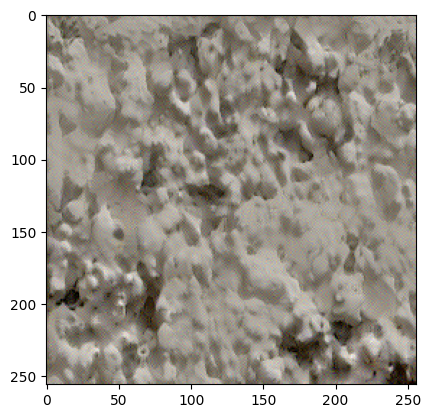

In [8]:
# VIEW the result

 
result=load_image(OUT_PATH)
plt.imshow(result[0][:256,:256,:])

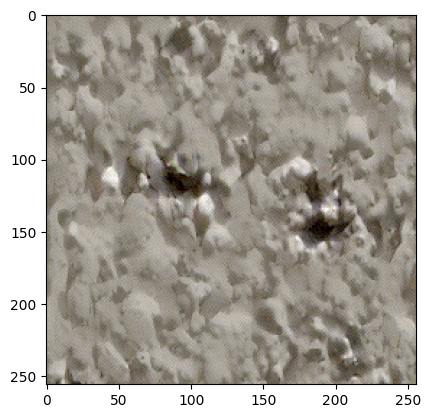

In [22]:
# Result of only lower-level layers
result1=load_image(OUT_PATH)
plt.imshow(result[0][:256,:256,:])

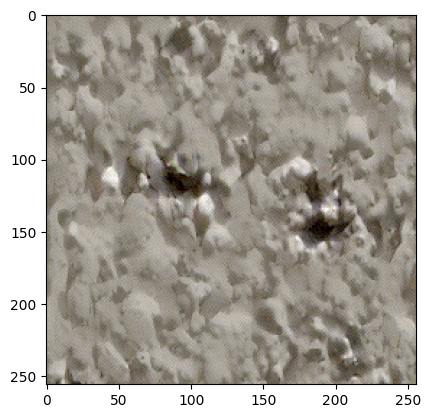

In [16]:
# Result of combination of lower and middle-level layers:
result2=load_image(OUT_PATH)
plt.imshow(result[0][:256,:256,:])

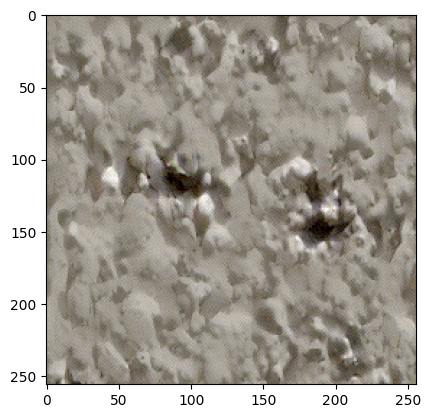

In [27]:
# Result of only middle-level layers:
result3=load_image(OUT_PATH)
plt.imshow(result[0][:256,:256,:])

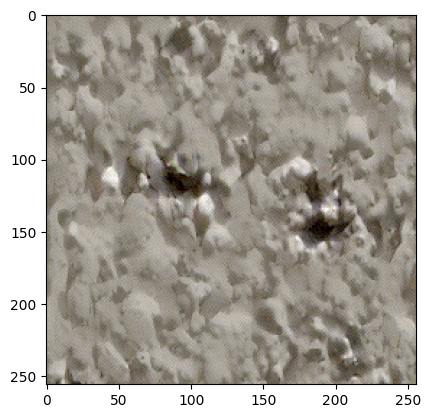

In [32]:
# Result of a combination of middle and higher-level layers:
result4=load_image(OUT_PATH)
plt.imshow(result[0][:256,:256,:])

__ANSWER__

__1)__
Dans le programme, les couches convolutives intermédiaires du réseau VGG19 ont été choisies pour caractériser les textures. Plus précisément, les activations des couches convolutives 1_1, 2_1, 3_1 et 4_1 sont utilisées pour calculer les matrices de Gram, qui sont ensuite utilisées pour évaluer la perte de texture.

Pour générer une texture de notre choix avec le programme, il suffit de modifier les images de texture utilisées pour le calcul des matrices de Gram. Par exemple, nous pouvons remplacer l'image de texture "....jpg" utilisée dans le programme par une autre image de notre choix. Pour ce faire, nous devons simplement remplacer le chemin d'accès de l'image de texture dans le programme avec le chemin d'accès de notre propre image.

__2)__ 

First of all I noticed that, reducing the number of layers and using lower lever layers reduces time of computition. On the other hand, lower-level layers capture more fine-grained details, like edges and textures, while higher-level layers capture more abstract features and larger structures. By experimenting with different layer combinations, I gain insights into how these layers contribute to the texture synthesis process. Then I decided that best combination was the default one you defined.

__3)__

The Adam optimizer is used for the optimization process.